<a href="https://colab.research.google.com/github/MAHESH20L/Sentiment_analysis_of_tweets/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

from torch.utils.data import Dataset


In [ ]:
df = pd.read_csv("BTC_tweets_daily_example.csv")
print(df.head())


  Unnamed: 0                            Date  \
0          0  Fri Mar 23 00:40:32 +0000 2018   
1          1  Fri Mar 23 00:40:34 +0000 2018   
2          2  Fri Mar 23 00:40:35 +0000 2018   
3          3  Fri Mar 23 00:40:36 +0000 2018   
4          4  Fri Mar 23 00:40:36 +0000 2018   

                                               Tweet     Screen_name  \
0  RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...  myresumerocket   
1  @lopp @_Kevin_Pham @psycho_sage @naval But @Pr...        BitMocro   
2  RT @tippereconomy: Another use case for #block...    hojachotopur   
3                 free coins https://t.co/DiuoePJdap   denies_distro   
4  RT @payvxofficial: WE are happy to announce th...      aditzgraha   

                                         Source  \
0                                            []   
1                                  [u'Bitcoin']   
2  [u'blockchain', u'Tipper', u'TipperEconomy']   
3                                            []   
4                      

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text


In [ ]:
df["Tweet"] = df["Tweet"].astype(str)
df["Tweet"] = df["Tweet"].apply(clean_text)

# Remove rows without labels
df = df.dropna(subset=["New_Sentiment_State"])


In [ ]:
label_mapping = {
    label: idx for idx, label in enumerate(sorted(df["New_Sentiment_State"].unique()))
}

df["label"] = df["New_Sentiment_State"].map(label_mapping)

num_labels = len(label_mapping)
print("Label mapping:", label_mapping)


Label mapping: {np.float64(-1.0): 0, np.float64(0.0): 1, np.float64(1.0): 2}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df["Tweet"],
    df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)


In [ ]:
MODEL_NAME = "distilroberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights:   0%|          | 0/101 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: distilroberta-base
Key                         | Status     | 
----------------------------+------------+-
lm_head.layer_norm.bias     | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.weight  | MISSING    | 
classifier.out_proj.bias    | MISSING    | 
classifier.dense.bias       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [ ]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts.tolist(),
            truncation=True,
            padding=True,
            max_length=128
        )
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
train_dataset = TweetDataset(X_train, y_train)
test_dataset = TweetDataset(X_test, y_test)


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,        # 🔥 FAST
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=100,
    save_strategy="no",
    eval_strategy="no",
    fp16=True,                 # 🔥 MUCH FASTER ON GPU
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset
)

In [ ]:
trainer.train()

Step,Training Loss
100,0.824642
200,0.438055
300,0.342024
400,0.292431
500,0.248264
600,0.246954
700,0.171308
800,0.195838
900,0.157617
1000,0.153829


TrainOutput(global_step=1272, training_loss=0.2765104238342189, metrics={'train_runtime': 109.0079, 'train_samples_per_second': 373.193, 'train_steps_per_second': 11.669, 'total_flos': 831506221697598.0, 'train_loss': 0.2765104238342189, 'epoch': 1.0})

In [ ]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=[str(key) for key in label_mapping.keys()]))

Accuracy: 0.9584111690099302

Classification Report:

              precision    recall  f1-score   support

        -1.0       0.93      0.87      0.90      1313
         0.0       0.95      0.98      0.96      4349
         1.0       0.97      0.97      0.97      4509

    accuracy                           0.96     10171
   macro avg       0.95      0.94      0.94     10171
weighted avg       0.96      0.96      0.96     10171



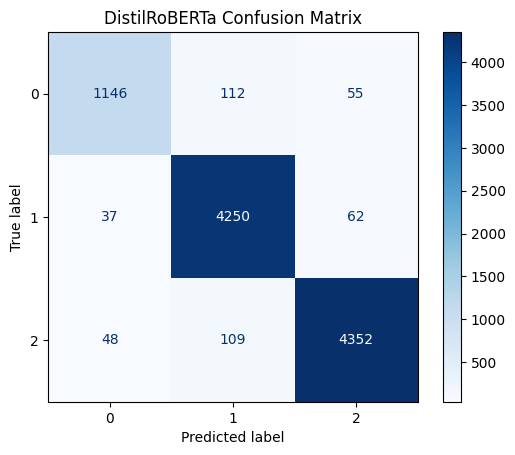

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("DistilRoBERTa Confusion Matrix")
plt.show()


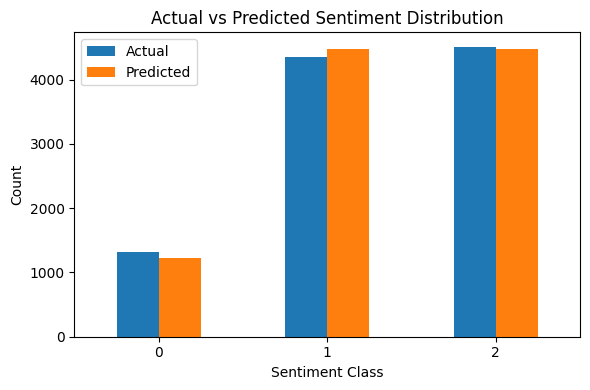

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert numeric labels to Series
actual_counts = pd.Series(y_test).value_counts().sort_index()
pred_counts = pd.Series(y_pred).value_counts().sort_index()

# Align indexes so missing classes don't cause NaN
df_plot = pd.DataFrame({
    "Actual": actual_counts,
    "Predicted": pred_counts
}).fillna(0)

# Plot
df_plot.plot(
    kind="bar",
    figsize=(6,4)
)

plt.title("Actual vs Predicted Sentiment Distribution")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


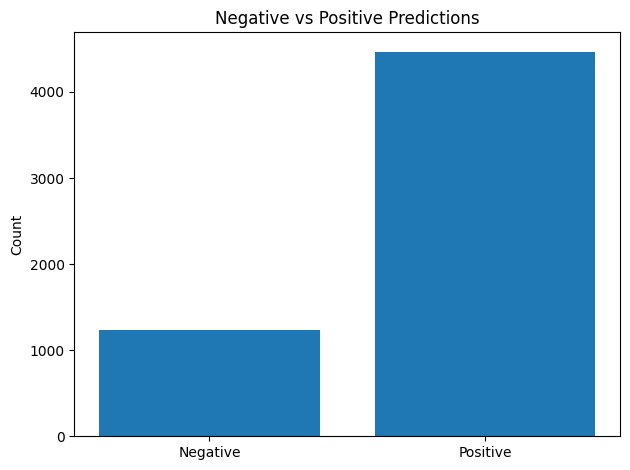

In [ ]:
import matplotlib.pyplot as plt

neg_pos = {
    "Negative": pred_counts.get(0, 0),   # class 0
    "Positive": pred_counts.get(2, 0)    # class 2
}

plt.bar(neg_pos.keys(), neg_pos.values())
plt.title("Negative vs Positive Predictions")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


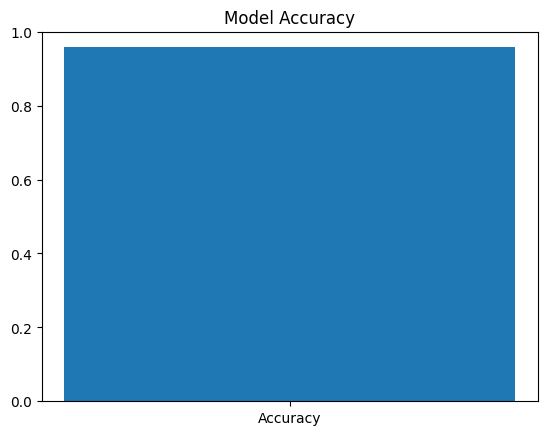

In [ ]:
acc = accuracy_score(y_test, y_pred)

plt.bar(["Accuracy"], [acc])
plt.ylim(0, 1)
plt.title("Model Accuracy")
plt.show()


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load DistilRoBERTa
MODEL_NAME = "distilroberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3
)

model.eval()

# Input sentence
sentence = "I just love how Bitcoin destroyed my savings today"

# Tokenize
inputs = tokenizer(
    sentence,
    return_tensors="pt",
    truncation=True,
    padding=True
)

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)

# Labels (model output space: 0,1,2)
labels = {
    0: "Negative 😡",
    1: "Neutral 😐",
    2: "Positive 😊"
}

# Max-probability decision
pred_id = torch.argmax(probs).item()

# Output
print("Sentence:", sentence)
print("Probabilities:")
print("Negative:", round(probs[0][0].item(), 3))
print("Neutral :", round(probs[0][1].item(), 3))
print("Positive:", round(probs[0][2].item(), 3))
print("\nFinal Prediction (max prob):", labels[pred_id])


Loading weights:   0%|          | 0/101 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: distilroberta-base
Key                         | Status     | 
----------------------------+------------+-
lm_head.layer_norm.bias     | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.weight  | MISSING    | 
classifier.out_proj.bias    | MISSING    | 
classifier.dense.bias       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Sentence: I just love how Bitcoin destroyed my savings today
Probabilities:
Negative: 0.362
Neutral : 0.324
Positive: 0.315

Final Prediction (max prob): Negative 😡
